In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import os
import pandas as pd
import scipy.io
import soundfile as sf
import noisereduce as nr
from scipy.io import wavfile
from pydub import AudioSegment
from  pydub.silence import detect_nonsilent

In [2]:
keywords = ['Backward','Birds','Continue','Down','Forward', 'Four','Landing','Left','Light','Look','Off','On','One',
            'Reverse','Right','Rotate','Side','Snapshot','Stop','Task','Three','Two','Up']
sr = 40000
subject_number = 11

In [3]:
s = 0 # s is the subject No., here from 0 to 10, set a No. to get this subject data, e.g., set s=0 to get subject 1 data
sub = str(s+1).zfill(2) # get the subject #
word = 'Continue' # word is the keyword, select one from the list of keywords


# Extract the audio data apart from the raw “.mat” data. 

In [4]:
#get the mat file of this word from the subject s and get the labels of all segmentations
mat_path = '/data2/home/cou/yuli5/HCI_paper/sEMG_lab1208/subject_'+sub+'/'+word+'.mat'
mat = scipy.io.loadmat(mat_path)

# get the data of this channel in this word from the subject s 
if len(mat['tickrate'][0])>1:# just in case some files have a pause during recording
    for i in range(len(mat['tickrate'][0])): 
        seg_data = mat['data'][0][int(mat['datastart'][-1][i]):int(mat['dataend'][-1][i])] 
        seg_data = np.transpose(seg_data)
        data = np.append(data,seg_data) if i > 0 else seg_data
else:
    data = mat['data'][0][int(mat['datastart'][-1]):int(mat['dataend'][-1])] # achive the last channel data which is audio
    data = np.transpose(data)   
    

In [5]:
# save audio data as ".wav" file
original_save_path = 'subject_'+sub+'_'+word+'_original.wav'
sf.write(original_save_path, data, sr)

#noise reduction  
rate, data = wavfile.read(original_save_path)
y = nr.reduce_noise(y=data, sr=rate) 

# save the clear audio data as ".wav" file
clear_save_path = 'subject_'+sub+'_'+word+'_clear.wav'
sf.write(clear_save_path, y , sr) 

  0%|          | 0/11 [00:00<?, ?it/s]

#  Split data in 1.5s segments

In [6]:
#revised from https://github.com/jiaaro/pydub/blob/master/pydub/silence.py
import itertools
def split_on_silence(audio_segment, min_silence_len=500, silence_thresh=-16, fix_len = 1500,
                     seek_step=1):

    # from the itertools documentation
    def pairwise(iterable):
        "s -> (s0,s1), (s1,s2), (s2, s3), ..."
        a, b = itertools.tee(iterable)
        next(b, None)
        return zip(a, b)
    
    output_ranges = []
    for (start,end) in detect_nonsilent(audio_segment, min_silence_len, silence_thresh, seek_step):
        
        if end - start < 1500:
            expand = int((fix_len - ( end - start)) /2)
            output_ranges.append([ start - expand, end + expand ])
        else:
            output_ranges.append([ start, end ])

            
    if output_ranges[0][0]<0:
        output_ranges[0][0] =  output_ranges[0][0] + (0-output_ranges[0][0])
        output_ranges[0][1] =  output_ranges[0][1] + (0-output_ranges[0][0])
        
    if output_ranges[-1][0]<output_ranges[-2][1]:
        del output_ranges[-1]
    elif output_ranges[-1][1]>len(audio_segment):
        output_ranges[-1][0] =  output_ranges[-1][0] - (output_ranges[-1][1] - len(audio_segment))
        output_ranges[-1][1] =  output_ranges[-1][1] - (output_ranges[-1][1] - len(audio_segment))
        
    return output_ranges

In [7]:
# get the dBFS data 
path = 'subject_'+sub+'_'+word+'_clear.wav'
sound = AudioSegment.from_wav(path)
dBFS = sound.dBFS

In [8]:
#segmentation based on silence segments

min_sile = 500
silence_thres = 16
segment_len = 1500

chunks = split_on_silence(sound, 
    min_silence_len = min_sile,
    silence_thresh = dBFS-silence_thres,
fix_len=segment_len)
# to check if any segment is longer than 1.5 sec
for i in range(0,len(chunks)):
    if (chunks[i][1]-chunks[i][0]) > 1500:
        print("Warning: there is a word from subject "+ sub +" keywords "+ word +" length longer than 1.5 sec")

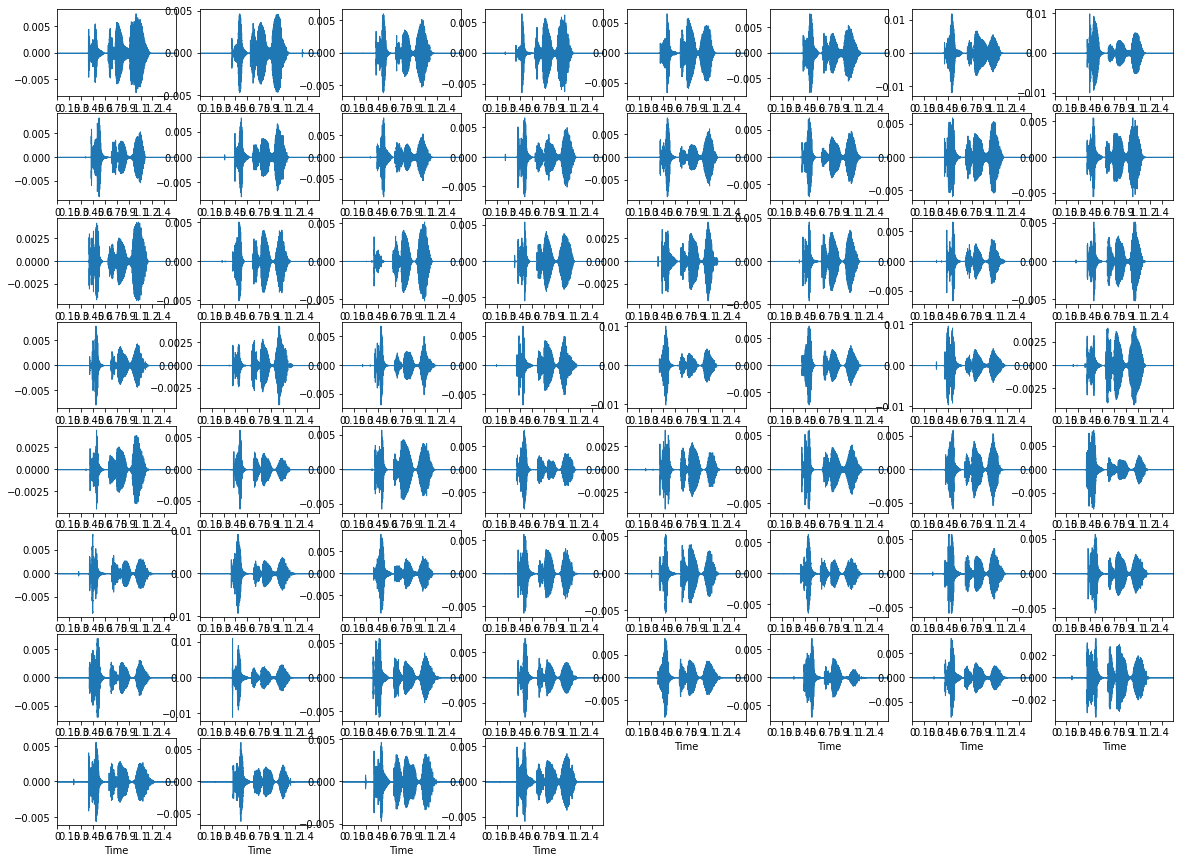

In [9]:
# visualization of the segmentations
plt.figure(figsize=(20,15))
y, sr = librosa.load(path, sr=40000)                        
for i in range(len(chunks)):
    plt.subplot(8,8,i+1)
    librosa.display.waveplot(y[int(40*chunks[i][0]):int(40*chunks[i][1])] , sr = 40000)

plt.show()

In [10]:
# create a dataframe to save the start/end index for each 1.5 segments
Alignment = pd.DataFrame()
for i in range(len(chunks)-1):               
    data = y[40*chunks[i][0]:40*chunks[i][1]] 

    Alignment = Alignment.append({'subject': sub,'keyword': word,'wav_index': i+1,
                  'Start': 40*chunks[i][0],'End': 40*chunks[i][1]}, ignore_index=True)
Alignment

,End,Start,keyword,subject,wav_index
0,135760.0,75800.0,Continue,01,1.0
1,243440.0,183440.0,Continue,01,2.0
2,345440.0,285440.0,Continue,01,3.0
3,442560.0,382600.0,Continue,01,4.0
4,556200.0,496240.0,Continue,01,5.0
5,654000.0,594040.0,Continue,01,6.0
6,759880.0,699920.0,Continue,01,7.0
7,872320.0,812360.0,Continue,01,8.0
8,981480.0,921480.0,Continue,01,9.0
9,1087840.0,1027880.0,Continue,01,10.0


# Assign labels of Train, Val, and Test to each segment

In [11]:
# know the exact number of file, around 55 segments / subject / word
file_count = int(Alignment.loc[(Alignment ["keyword"] == word)&(Alignment ["subject"] == sub),"wav_index"].values[-1]  ) 

# generate a random value to label train, val and test
rnd = np.random.rand(file_count)
sort = np.sort(rnd)
split_value_1 = sort[int(len(sort)*0.6)] #60% training 
split_value_2 = sort[int(len(sort)*0.8)] #20% val and 20% test
label =  np.array(["Empty"]*file_count)
label[rnd <= split_value_1] = "Train"
label[rnd >= split_value_2] = "Test"
label[(rnd > split_value_1)&(rnd < split_value_2)] = "Val"
Alignment.loc[(Alignment ["keyword"] == word)&(Alignment ["subject"] == sub),"Label"] = label
Alignment

,End,Start,keyword,subject,wav_index,Label
0,135760.0,75800.0,Continue,01,1.0,Val
1,243440.0,183440.0,Continue,01,2.0,Train
2,345440.0,285440.0,Continue,01,3.0,Val
3,442560.0,382600.0,Continue,01,4.0,Train
4,556200.0,496240.0,Continue,01,5.0,Train
5,654000.0,594040.0,Continue,01,6.0,Train
6,759880.0,699920.0,Continue,01,7.0,Train
7,872320.0,812360.0,Continue,01,8.0,Test
8,981480.0,921480.0,Continue,01,9.0,Train
9,1087840.0,1027880.0,Continue,01,10.0,Train
